In [38]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import seaborn as sns
from collections import Counter
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import matplotlib.pyplot as plt
from pyts.transformation import ShapeletTransform
import pickle
from sklearn.ensemble import GradientBoostingRegressor

In [39]:
#Making a list of missing values types
missingValues = ["n/a", "na", " ", "__"]
data = pd.read_csv("/Users/aniketsingh/Desktop/SeniorProject/data/ele.csv",na_values = missingValues)

data.rename(columns = {'Unnamed: 0': 'Timestamp'}, inplace = True)
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
# data.set_index('Timestamp', inplace=True)

#First few rows
data.head()
data

,Timestamp,mels_S,lig_S,lig_N,mels_N,hvac_N,hvac_S
0,2018-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,36.000000,22.500000
1,2018-01-01 00:30:00+00:00,NaN,NaN,NaN,NaN,37.700001,19.200001
2,2018-01-01 01:00:00+00:00,1.250000,0.200000,NaN,7.150000,37.450001,19.695000
3,2018-01-01 01:30:00+00:00,1.150000,0.200000,NaN,7.550000,37.600000,19.094999
4,2018-01-01 02:00:00+00:00,1.100000,0.200000,NaN,7.300000,37.300001,24.800000
...,...,...,...,...,...,...,...
35036,2019-12-31 22:00:00+00:00,1.795833,0.005556,NaN,8.585667,22.446974,23.104355
35037,2019-12-31 22:30:00+00:00,1.827083,0.000000,NaN,8.475536,23.469722,27.520789
35038,2019-12-31 23:00:00+00:00,1.754444,0.050000,NaN,8.572000,24.113158,25.355263
35039,2019-12-31 23:30:00+00:00,1.898889,0.386250,NaN,8.466270,24.302632,26.358289


In [40]:
data['weekNumber'] = data['Timestamp'].dt.week

<ipython-input-40-89160ae1167f>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data['weekNumber'] = data['Timestamp'].dt.week


In [41]:
data_first_week = data[data['weekNumber']==1]
data_last_week = data[data['weekNumber']==52]

In [48]:
data['hour']=data['Timestamp'].dt.hour


In [47]:
data = pd.concat([data_first_week,data_last_week],axis=0,ignore_index=True)
data

,Timestamp,mels_S,lig_S,lig_N,mels_N,hvac_N,hvac_S,weekNumber
0,2018-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,36.000000,22.500000,1
1,2018-01-01 00:30:00+00:00,NaN,NaN,NaN,NaN,37.700001,19.200001,1
2,2018-01-01 01:00:00+00:00,1.250000,0.2,NaN,7.150000,37.450001,19.695000,1
3,2018-01-01 01:30:00+00:00,1.150000,0.2,NaN,7.550000,37.600000,19.094999,1
4,2018-01-01 02:00:00+00:00,1.100000,0.2,NaN,7.300000,37.300001,24.800000,1
...,...,...,...,...,...,...,...,...
1436,2019-12-29 21:30:00+00:00,1.838095,0.2,NaN,7.957500,20.295583,6.467895,52
1437,2019-12-29 22:00:00+00:00,1.685417,0.2,NaN,7.738571,19.957368,14.391053,52
1438,2019-12-29 22:30:00+00:00,1.800000,0.2,NaN,8.506111,21.036868,12.956868,52
1439,2019-12-29 23:00:00+00:00,1.810000,0.2,NaN,8.041857,20.385774,11.979673,52


In [43]:
data = data.drop(columns = ['mels_S','lig_S','lig_N','mels_N','weekNumber'])
data.set_index('Timestamp', inplace=True)
data

,hvac_N,hvac_S
Timestamp,,
2018-01-01 00:00:00+00:00,36.000000,22.500000
2018-01-01 00:30:00+00:00,37.700001,19.200001
2018-01-01 01:00:00+00:00,37.450001,19.695000
2018-01-01 01:30:00+00:00,37.600000,19.094999
2018-01-01 02:00:00+00:00,37.300001,24.800000
...,...,...
2019-12-29 21:30:00+00:00,20.295583,6.467895
2019-12-29 22:00:00+00:00,19.957368,14.391053
2019-12-29 22:30:00+00:00,21.036868,12.956868


In [19]:
#Total missing values for each feature 
print("-------------Here are the missing values----------")
data.isnull().sum()

-------------Here are the missing values----------


hvac_N    112
hvac_S    112
dtype: int64

In [20]:
# -------- Removing Missing Values-----#

data = data.dropna()
print("-------------Here are the missing values----------")
data.isnull().sum()

-------------Here are the missing values----------


hvac_N    0
hvac_S    0
dtype: int64

<AxesSubplot:xlabel='hour'>

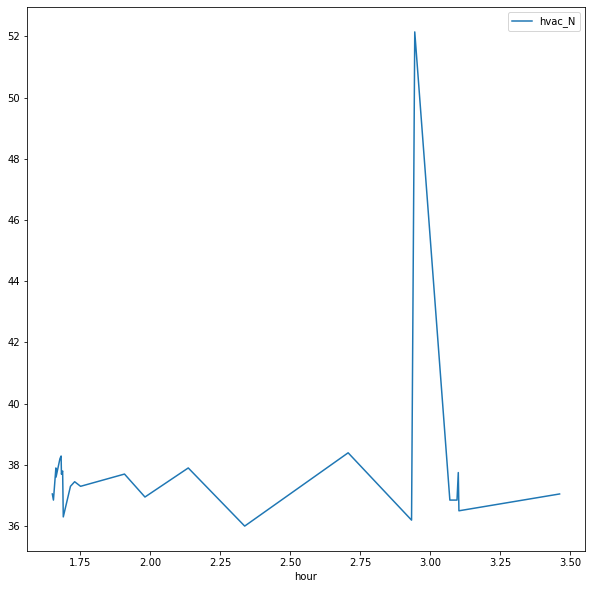

In [108]:
#data[['hour','hvac_N']].col('hour').mean()
#data.groupby('hour').mean()
newData = data[['hour','hvac_N']].groupby('hour').mean()

newData.plot( figsize=(10, 10))

In [109]:
newData2 = data[['hour','hvac_S']].groupby('hour').mean()


<AxesSubplot:xlabel='hour'>

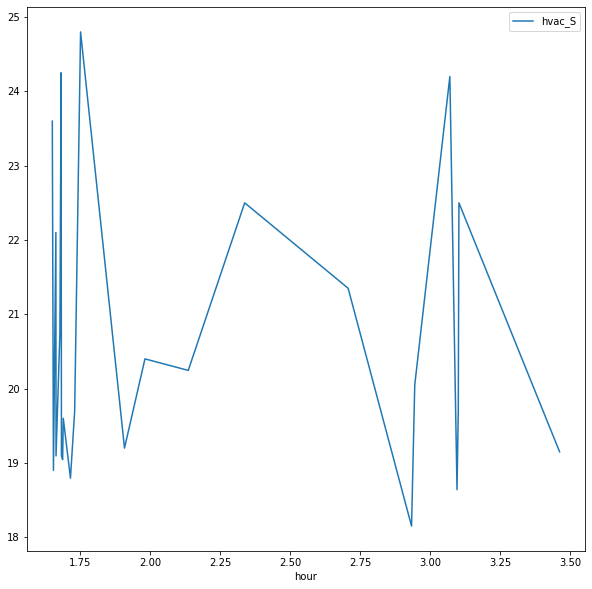

In [110]:
newData2.plot( figsize=(10, 10))

In [21]:
# --------- Normalized-------#
scaler = MinMaxScaler()
data_norm = data.copy()
data_norm[:] = scaler.fit_transform(data_norm)
data_norm.head(1)

,hvac_N,hvac_S
Timestamp,,
2018-01-01 00:00:00+00:00,0.547529,0.434783


In [22]:
def is_outlier(data, rolling_median, thresh):
    if not pd.isna(rolling_median):
        return abs(data - rolling_median) >= thresh

In [23]:
data_nrm5 = data_norm.rolling(5, center=True).median()
data_nc = data_norm.copy()
s = data_nc.shape
for j in range(s[1]):
    for i in range(s[0]):
        if is_outlier(data_nc.iloc[i, j], data_nrm5.iloc[i, j], 0.2):
            data_nc.iloc[i, j] = data_nrm5.iloc[i, j]

In [24]:
def ts_to_features(ts, n_features=48):
    X, y = np.zeros([len(ts) - n_features, n_features]), np.zeros([len(ts) - n_features, 1])
    for i in range(len(ts)-n_features):
        X[i, :] = ts[i:i+n_features]
        y[i] = ts[i+n_features]
    return X, y.flatten()

In [25]:
def ts_predict(X, y):
    lower_alpha = 0.1
    upper_alpha = 0.9
    predictions = np.ones([1, 4])
    for i in tqdm(range(1, X.shape[0])):
        lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=lower_alpha)
        mid_model = GradientBoostingRegressor(loss="ls")
        upper_model = GradientBoostingRegressor(loss="quantile",
                                                alpha=upper_alpha)
        lower_model.fit(X[:i,:], y[:i])
        mid_model.fit(X[:i,:], y[:i])
        upper_model.fit(X[:i,:], y[:i])
        
        pred = np.hstack([y[i], 
                          lower_model.predict(X[i:i+1, :]),
                          mid_model.predict(X[i:i+1, :]),
                          upper_model.predict(X[i:i+1, :])])
        predictions = np.vstack([predictions, pred])
    return predictions[1:, :]

# hvac_N

In [26]:
h = data_nc.iloc[:, 0].values
h = h[range(0, len(h), 48)]
X, y = ts_to_features(h, 5)
p = ts_predict(X, y)

<ipython-input-25-bed56b3e746d>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(1, X.shape[0])):


In [27]:
p = pd.DataFrame(p)
p.columns = ['actual', 'lower', 'mid', 'upper']
p['label'] = np.ones(len(p))
for i in range(len(p)):
    if p['actual'].iloc[i] > p['upper'].iloc[i]:
        p['label'].iloc[i] = 2
    if p['actual'].iloc[i] < p['lower'].iloc[i]:
        p['label'].iloc[i] = 0

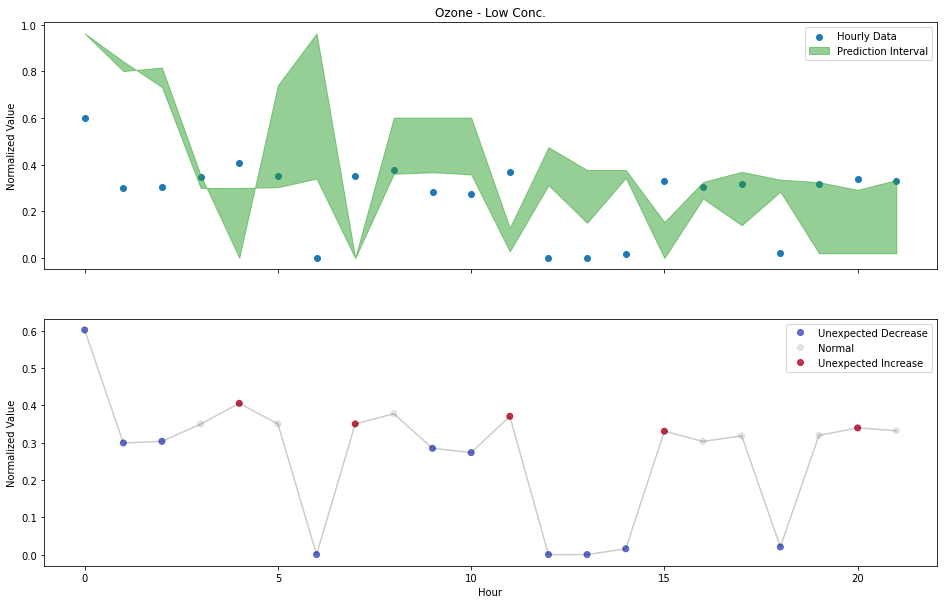

In [28]:
# Plot two scatter plots, showing the prediction interval and labels
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 10))
ax1.scatter(p.index, p['actual'], color='tab:blue', alpha=1, label='Hourly Data')
ax1.fill_between(p.index, p['upper'], p['lower'], color='tab:green', alpha=0.5, label='Prediction Interval')
ax1.set_ylabel('Normalized Value')
ax1.legend()
ax1.set_title('Ozone - Low Conc.')
ax2.plot(p['actual'], color='black', alpha=0.2)
scatter = ax2.scatter(p.index, p['actual'], c=p['label'], cmap=plt.get_cmap('coolwarm'), alpha=0.8)
ax2.set_xlabel('Hour')
ax2.set_ylabel('Normalized Value')
ax2.legend(handles=scatter.legend_elements()[0], labels=['Unexpected Decrease', 'Normal', 'Unexpected Increase'])
plt.show()

# hvac_S


In [29]:
h = data_nc.iloc[:, 1].values
h = h[range(0, len(h), 48)]
X, y = ts_to_features(h, 5)
p = ts_predict(X, y)

<ipython-input-25-bed56b3e746d>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(1, X.shape[0])):


In [30]:
p = pd.DataFrame(p)
p.columns = ['actual', 'lower', 'mid', 'upper']
p['label'] = np.ones(len(p))
for i in range(len(p)):
    if p['actual'].iloc[i] > p['upper'].iloc[i]:
        p['label'].iloc[i] = 2
    if p['actual'].iloc[i] < p['lower'].iloc[i]:
        p['label'].iloc[i] = 0

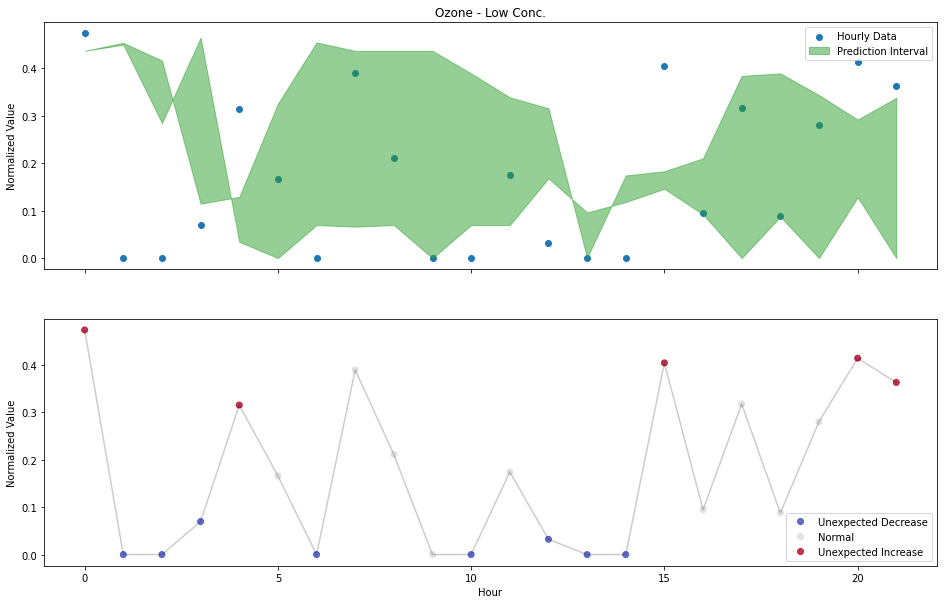

In [31]:
# Plot two scatter plots, showing the prediction interval and labels
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 10))
ax1.scatter(p.index, p['actual'], color='tab:blue', alpha=1, label='Hourly Data')
ax1.fill_between(p.index, p['upper'], p['lower'], color='tab:green', alpha=0.5, label='Prediction Interval')
ax1.set_ylabel('Normalized Value')
ax1.legend()
ax1.set_title('Ozone - Low Conc.')
ax2.plot(p['actual'], color='black', alpha=0.2)
scatter = ax2.scatter(p.index, p['actual'], c=p['label'], cmap=plt.get_cmap('coolwarm'), alpha=0.8)
ax2.set_xlabel('Hour')
ax2.set_ylabel('Normalized Value')
ax2.legend(handles=scatter.legend_elements()[0], labels=['Unexpected Decrease', 'Normal', 'Unexpected Increase'])
plt.show()

# hvac_S + hvac_N

In [32]:
h = data_nc.iloc[:,0].values + data_nc.iloc[:,1].values
h = h[range(0, len(h), 48)]
X, y = ts_to_features(h, 5)
p = ts_predict(X, y)

<ipython-input-25-bed56b3e746d>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(1, X.shape[0])):


In [33]:
p = pd.DataFrame(p)
p.columns = ['actual', 'lower', 'mid', 'upper']
p['label'] = np.ones(len(p))
for i in range(len(p)):
    if p['actual'].iloc[i] > p['upper'].iloc[i]:
        p['label'].iloc[i] = 2
    if p['actual'].iloc[i] < p['lower'].iloc[i]:
        p['label'].iloc[i] = 0

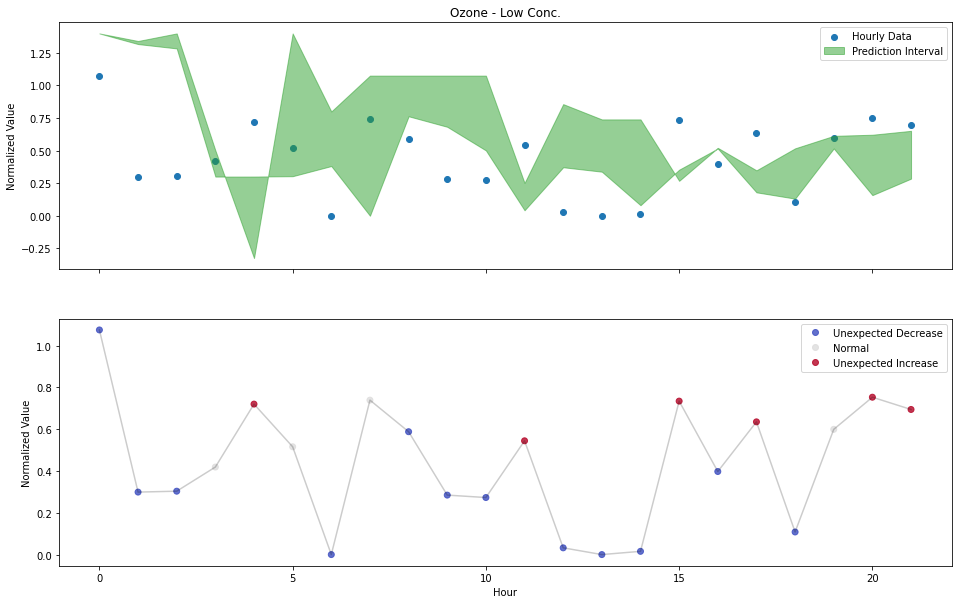

In [34]:
# Plot two scatter plots, showing the prediction interval and labels
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 10))
ax1.scatter(p.index, p['actual'], color='tab:blue', alpha=1, label='Hourly Data')
ax1.fill_between(p.index, p['upper'], p['lower'], color='tab:green', alpha=0.5, label='Prediction Interval')
ax1.set_ylabel('Normalized Value')
ax1.legend()
ax1.set_title('Ozone - Low Conc.')
ax2.plot(p['actual'], color='black', alpha=0.2)
scatter = ax2.scatter(p.index, p['actual'], c=p['label'], cmap=plt.get_cmap('coolwarm'), alpha=0.8)
ax2.set_xlabel('Hour')
ax2.set_ylabel('Normalized Value')
ax2.legend(handles=scatter.legend_elements()[0], labels=['Unexpected Decrease', 'Normal', 'Unexpected Increase'])
plt.show()